# 1. Подготовка


## 1.1 Установка зависимостей


#### WSL 2.0

In [ ]:
!pip install tf-nightly[and-cuda] keras opencv-python matplotlib

#### Windows

In [ ]:
!conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 matplotlib

In [ ]:
!pip install "tensorflow<2.11"

#### Проверка доступности CUDA & cuDNN


In [ ]:
!python scripts/check_cuda.py

## 1.2 Импортирование стандартных зависимостей


In [1]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt

## 1.3 Импортирование зависимостей TensorFlow (Функциональный API)


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.4 Установка роста потребления памяти GPU для предотвращения ошибо OOM.


In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 1.5 Создание структуры директорий


#### Установка путей


In [7]:
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

INPUT_IMG_DIR_PATH = os.path.join("app_data", "input_image")
VERIF_IMG_DIR_PATH = os.path.join("app_data", "verification_images")

INPUT_IMG_PATH = os.path.join(INPUT_IMG_DIR_PATH, "input_image.jpg")

DIRECTORIES = [POS_PATH, NEG_PATH, ANC_PATH, INPUT_IMG_DIR_PATH, VERIF_IMG_DIR_PATH]

#### Создание директорий


In [8]:
for dir_path in DIRECTORIES:
    try:
        os.makedirs(dir_path)
    except FileExistsError:
        print(f"Директория {dir_path} уже существует")

Директория data\positive уже существует
Директория data\negative уже существует
Директория data\anchor уже существует
Директория app_data\input_image уже существует
Директория app_data\verification_images уже существует


# 2 Сбор данных


Скачать все изображения в виде gzip-tar-файла https://vis-www.cs.umass.edu/lfw/#download


## 2.1 Распаковка набора данных


In [9]:
DATASET_NAME = "lfw"
DATASET_EXTENSION = ".tgz"

In [10]:
import tarfile

try:
    with tarfile.open(DATASET_NAME + DATASET_EXTENSION, "r:gz") as tar:
        tar.extractall()
except FileNotFoundError as e:
    print(e.strerror)

No such file or directory


In [11]:
try:
    os.remove(DATASET_NAME + DATASET_EXTENSION)
except OSError as e:
    print(e.strerror)

The system cannot find the file specified


## 2.2 Перемещение изображений в директорию data/negative


In [12]:
try:
    for directory in os.listdir(DATASET_NAME):
        for file in os.listdir(os.path.join(DATASET_NAME, directory)):
            ex_path = os.path.join(DATASET_NAME, directory, file)
            new_path = os.path.join(NEG_PATH, file)
            os.replace(ex_path, new_path)
except FileNotFoundError as e:
    print(e.strerror)

The system cannot find the path specified


In [13]:
try:
    os.rmdir(DATASET_NAME)
except OSError as e:
    print(e.strerror)

The system cannot find the file specified


## 2.3 Сбор позитивных и якорных изображений


#### Библиотека для создания уникальных названий изображений.


In [14]:
import uuid

In [15]:
def write_an_image(key: str, path: str):
    if cv2.waitKey(1) & 0xFF == ord(key):
        # Создание уникального названия изображения
        imgname = os.path.join(path, "{}.jpg".format(uuid.uuid1()))
        # Запись образца
        cv2.imwrite(imgname, frame)
        print(f"Сохранено изображение {imgname}")

In [13]:
# Установка соединения с веб-камерой
cap = cv2.VideoCapture(0)

# # Отключение панели инструментов OpenCV
# cv2.namedWindow("Image Collection", cv2.WINDOW_GUI_NORMAL)

while cap.isOpened():
    ret, frame = cap.read()

    # Обрезание кадра до 250x250px
    frame = frame[115: 115 + 250, 195: 195 + 250, :]

    write_an_image("a", ANC_PATH)
    write_an_image("p", POS_PATH)
    write_an_image("n", NEG_PATH)

    cv2.imshow("Image Collection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

Сохранено изображение data\negative\9a00f102-b1eb-11ee-a3ac-00155d8903d8.jpg
Сохранено изображение data\negative\9a0f4ea4-b1eb-11ee-92f2-00155d8903d8.jpg
Сохранено изображение data\negative\9a20127e-b1eb-11ee-b452-00155d8903d8.jpg
Сохранено изображение data\negative\9b43616c-b1eb-11ee-822c-00155d8903d8.jpg
Сохранено изображение data\negative\9b51c183-b1eb-11ee-b6db-00155d8903d8.jpg
Сохранено изображение data\negative\9f70080f-b1eb-11ee-9d0b-00155d8903d8.jpg
Сохранено изображение data\negative\9f853def-b1eb-11ee-a4fa-00155d8903d8.jpg
Сохранено изображение data\negative\9ffe987b-b1eb-11ee-b1ce-00155d8903d8.jpg
Сохранено изображение data\negative\a00cb1d5-b1eb-11ee-b5fc-00155d8903d8.jpg
Сохранено изображение data\negative\a0271abb-b1eb-11ee-91b5-00155d8903d8.jpg
Сохранено изображение data\negative\a03557a2-b1eb-11ee-b696-00155d8903d8.jpg
Сохранено изображение data\negative\a03c7e0f-b1eb-11ee-b0f7-00155d8903d8.jpg
Сохранено изображение data\negative\a0590001-b1eb-11ee-b2e8-00155d8903d8.jpg

## 2.4 Дополнение данных


In [12]:
def data_aug(img):
    data = []
    for i in range(5):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        img = tf.image.stateless_random_flip_left_right(
            img, seed=(np.random.randint(100), np.random.randint(100))
        )
        img = tf.image.stateless_random_jpeg_quality(
            img,
            min_jpeg_quality=90,
            max_jpeg_quality=100,
            seed=(np.random.randint(100), np.random.randint(100)),
        )
        img = tf.image.stateless_random_saturation(
            img,
            lower=0.9,
            upper=1,
            seed=(np.random.randint(100), np.random.randint(100)),
        )
        data.append(img)
    return data

In [13]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(
            os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1())), image.numpy()
        )

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(
            os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1())), image.numpy()
        )

# 3 Загрузка и предобработка изображений


## 3.1 Получение каталогов изображений


In [16]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, "*.jpg")).take(2473)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, "*.jpg")).take(13285)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, "*.jpg")).take(2473)

## 3.2 Предобработка - масштабирование и изменение размера


In [17]:
def preprocess(file_path):
    # Чтение изображения
    byte_img = tf.io.read_file(file_path)
    # Загрузка изображения
    img = tf.io.decode_jpeg(byte_img)
    # Изменение размера изображения на 105x105
    img = tf.image.resize(img, (105, 105))
    # Масштабирование изображения в диапазоне от 0 до 1
    img /= 255.0

    return img

## 3.3 Создание помеченного набора данных


In [18]:
positives = tf.data.Dataset.zip(
    (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
)

negatives = tf.data.Dataset.zip(
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
)

data = positives.concatenate(negatives)

## 3.4 Сборка тренировочных и тестовых данных


In [19]:
def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

#### Создание загрузчика данных


In [20]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

#### Данные для обучения


In [21]:
train_data = data.take(round(len(data) * 0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

#### Данные для тестирования


In [22]:
test_data = data.skip(round(len(data) * 0.8))
test_data = test_data.take(round(len(data) * 0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Разработка модели


## 4.1 Построение слоя внедрения


In [23]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name="input_image")

    # Первый блок
    c1 = Conv2D(64, (10, 10), activation=tf.nn.relu)(inp)
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)

    # Второй блок
    c2 = Conv2D(128, (7, 7), activation=tf.nn.relu)(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

    # Трейтий блок
    c3 = Conv2D(128, (4, 4), activation=tf.nn.relu)(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

    # Последний блок внедрения
    c4 = Conv2D(256, (4, 4), activation=tf.nn.relu)(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation=tf.nn.sigmoid)(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [24]:
embedding = make_embedding()

In [25]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## 4.2 Построение слоя расстояния


In [26]:
# Сиамский класс дистанции L1

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    # Вычисление схожести
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Создание сиамской модели


In [27]:
def make_siamese_model():
    input_image = Input(name="input_img", shape=(105, 105, 3))

    validation_image = Input(name="validation_img", shape=(105, 105, 3))

    # Объединение компонентов сиамского расстояния
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Слой классификации
    classifier = Dense(1, activation=tf.nn.sigmoid)(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [28]:
siamese_model = make_siamese_model()

In [29]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Обучение


## 5.1 Настройка потерь и оптимизатора


In [30]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

## 5.2 Установка контрольных точек


In [32]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, model=siamese_model)

## 5.3 Построение функции шага обучения


In [33]:
@tf.function
def train_step(batch):
    # Запись всех операций
    with tf.GradientTape() as tape:
        # Получение позитивного/негативного изображения
        x = batch[:2]
        # Получение метки
        y = batch[2]

        yhat = siamese_model(x, training=True)
        # Вычисление потерь
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Вычисление градиентов
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Вычисление обновленных весов и применение их к сиамской модели.
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## 5.4 Построение цикла обучения


In [34]:
# Импортирование классов для вычисления точности и памяти модели
from tensorflow.keras.metrics import Precision, Recall

In [35]:
def train(data, epochs):
    # Цикл по эпохам
    for epoch in range(1, epochs + 1):
        print("\n Эпоха {}/{}".format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))

        # Создание объектов метрик
        r = Recall()
        p = Precision()

        # Цикл по каждой партии
        for idx, batch in enumerate(data):
            # Запуск шага обучения
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx + 1)

        # Сохранение контрольных точек
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(loss.numpy(), r.result().numpy(), p.result().numpy())

## 5.5 Обучение модели


In [37]:
train(train_data, epochs=20)


 Эпоха 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
248/248 [==============================] - 134s 502ms/step
0.0006796179 0.60978043 0.97603834

 Эпоха 2/20
248/248 [==============================] - 123s 495ms/step
0.0069738426 0.95357144 0.9857595

 Эпоха 3/20
248/248 [==============================] - 123s 495ms/step
0.00914889 0.9764647 0.9933775

 Эпоха 4/20
248/248 [==============================] - 123s 496ms/step
0.056053847 0.98778003 0.99538225

 Эпоха 5/20
248/248 [==============================] - 123s 494ms/step
8.5433385e-07 0.9904905 0.99547285

 Эпоха 6/20
248/248 [==============================] - 125s 505ms/step
0.2023139 0.9954774 0.99647886

 Эпоха 7/20
248/248 [==============================] - 134s 539ms/step
0.0005323805 0.99745286 0.99593085

 Эпоха 8/20
248/248 [==============================] - 126s 508ms/step
0.06585618 0.99899346 0.9984909

 Э

# 6. Оценка модели


## 6.1 Прогнозы


In [36]:
# Получение партии тестовых данных
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [37]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 4s 4s/step


In [38]:
# Постобработка результатов
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]

In [39]:
y_true

array([0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

## 6.2 Вычисление показателей


In [40]:
# Создание экземпляров показателей
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    # Вычисление значений показателей
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)
# Вывод результатов
print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 918ms/step
0.7214429 0.47244096


## 6.3 Визуализация результатов


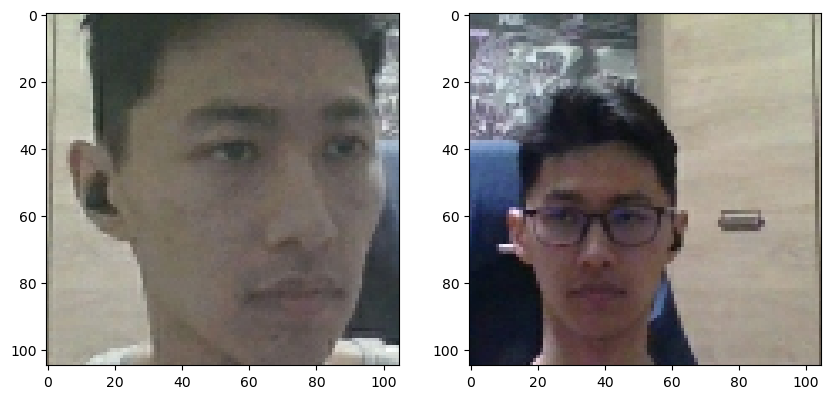

In [41]:
# Установка размера
plt.figure(figsize=(10, 8))

# Установка первого изображения
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

# Установка второго изображения
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])

plt.show()

# 7. Сохранение модели


In [61]:
MODEL_NAME: str = "siamese_model_v4.keras"

In [54]:
siamese_model.compile(optimizer='adam', loss=binary_cross_loss, metrics=['accuracy'])
siamese_model.save(MODEL_NAME)

# 8 Загрузка модели


In [55]:
siamese_model = tf.keras.models.load_model(
    MODEL_NAME, custom_objects={"L1Dist": L1Dist}
)

#### Оценка прогнозов загруженной модели


In [56]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 114ms/step


array([[1.0000000e+00],
       [9.9990726e-01],
       [1.0000000e+00],
       [1.0770076e-07],
       [1.0000000e+00],
       [7.2439580e-05],
       [2.8795396e-06],
       [1.0000000e+00],
       [7.1308165e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.3447997e-07],
       [9.9999988e-01]], dtype=float32)

In [57]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 9 Проверка работы модели в реальном времени


## 9.1 Функция подтверждения


In [58]:
for image in os.listdir(VERIF_IMG_DIR_PATH):
    validation_img = os.path.join(VERIF_IMG_DIR_PATH, image)
    print(validation_img)

app_data\verification_images\2a1c404c-b156-11ee-b6fa-00155d6fbe8c.jpg
app_data\verification_images\2a389a21-b156-11ee-92ab-00155d6fbe8c.jpg
app_data\verification_images\2a8d3fff-b156-11ee-807f-00155d6fbe8c.jpg
app_data\verification_images\2bcb7785-b156-11ee-b193-00155d6fbe8c.jpg
app_data\verification_images\2bd50544-b156-11ee-a204-00155d6fbe8c.jpg
app_data\verification_images\2bf1592d-b156-11ee-8ec0-00155d6fbe8c.jpg
app_data\verification_images\2c3e8450-b156-11ee-8242-00155d6fbe8c.jpg
app_data\verification_images\2c5b16ec-b156-11ee-ab86-00155d6fbe8c.jpg
app_data\verification_images\2c7ff8a3-b156-11ee-acb1-00155d6fbe8c.jpg
app_data\verification_images\2c9d1d13-b156-11ee-b752-00155d6fbe8c.jpg
app_data\verification_images\2d2cbc2f-b156-11ee-9d58-00155d6fbe8c.jpg
app_data\verification_images\2d5db730-b156-11ee-80a5-00155d6fbe8c.jpg
app_data\verification_images\2e1512f3-b156-11ee-974b-00155d6fbe8c.jpg
app_data\verification_images\2e643e9c-b156-11ee-b7e8-00155d6fbe8c.jpg
app_data\verificatio

In [59]:
def verify(model, detection_threshold, verification_threshold):
    # Построение массива результатов прогнозов
    results = []
    for image in os.listdir(VERIF_IMG_DIR_PATH):
        input_img = preprocess(INPUT_IMG_PATH)
        validation_img = preprocess(os.path.join(VERIF_IMG_DIR_PATH, image))

        # Результаты прогнозов
        result = model.predict(
            list(np.expand_dims([input_img, validation_img], axis=1))
        )
        results.append(result)

    # Порог обнаружения: Показатель, прогноз выше которого  считается положительным
    detection = np.sum(np.array(results) > detection_threshold)

    # Порог подтверждения: Доля положительных прогнозов / Общее количество положительных образцов
    verification = detection / len(os.listdir(VERIF_IMG_DIR_PATH))
    verified = verification > verification_threshold

    return results, verified

## 9.2 Распознавание лица в реальном времени с OpenCV


In [90]:
cap = cv2.VideoCapture(0)

# Отключение панели инструментов OpenCV
cv2.namedWindow("Verification", cv2.WINDOW_GUI_NORMAL)

while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow("Verification", frame)
    frame = frame[120: 120 + 250, 200: 200 + 250, :]

    # Триггер проверки
    if cv2.waitKey(1) & 0xFF == ord("v"):
        
        # Сохранение входного изображения в директорию app_data/input_image
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(INPUT_IMG_PATH, cut_frame)
        # Подтверждение
        results, verified = verify(siamese_model, 0.99, 0.98)
        print(results)
        print(verified)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
[array([[0.9999999]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[0.99614245]], dtype=float32), array([[0.99999976]], dtype=float32), array([[0.9992268]], dtype=float32), array([[0.99989974]], dtype=float32), array([[0.999931]], dtype=float32), array([[0.9999838]], dtype=float32), array([[0.99991]], dtype=float32), array([[0.9999982]], dtype=float32), array([[0.99892163]], dtype=float32), array([[1.]], dtype=float32), array([[0.9999882]], dtype=float32), array([[0.99998105]], dtype=float32), array([[0.99999976]], dtype=float32), array([[0.99998784]], dtype=float32), array([[1.]], dtype=float32), array([[0.99798113]], dtype=float32), array([[0.9999479]], dtype=float32)]
True
1/1 [==============================] - 0s 23ms/step
[array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[0.999316]], dtype=float32), array([[1.]], dtype=float32), array([[0.999997

KeyboardInterrupt: 

In [86]:
r = np.sum(np.squeeze(results) > 0.999999)

In [87]:
r

8

In [79]:
results

[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9948756]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999646]], dtype=float32),
 array([[0.99999344]], dtype=float32),
 array([[0.99999666]], dtype=float32),
 array([[0.9999989]], dtype=float32),
 array([[0.9999974]], dtype=float32),
 array([[0.9999989]], dtype=float32),
 array([[0.9999231]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999964]], dtype=float32),
 array([[0.9999989]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999989]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9919218]], dtype=float32),
 array([[0.99994063]], dtype=float32)]